# Project Part 2 Solutions

## (a)

In [66]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]

100

In [6]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [73]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))

def loss_func(alpha):
    ###### WRITE YOUR FUNCTION HERE
    Z = np.concatenate((S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))
    beta_new = beta_old * alpha
    soln = solve_ivp(
        SIR, (t[9], t[30]), Z, args=(N_node, beta_new, gamma), t_eval=t[9:30])
    
    L[node_index, 9:30] = Lc@soln.y[16:20]
    mse = mean_squared_error(L[node_index, 9:30], L_observed[node_index][9:30])
    
    return mse

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)

print(np.sort(alpha_predicted))

[0.13437347 0.14959717 0.15996704 0.16158829 0.16306152 0.16851807
 0.17086182 0.17155762 0.17612305 0.17961426 0.18221436 0.18603516
 0.18710937 0.19025879 0.20031738 0.20330505 0.20419922 0.20612793
 0.20684509 0.2128418  0.21408691 0.2162323  0.21859131 0.22739258
 0.23042603 0.23352203 0.24157715 0.24465332 0.24894104 0.25119629
 0.25798035 0.25991821 0.26757812 0.26948242 0.27169952 0.27301636
 0.28005524 0.28283691 0.28662109 0.28800049 0.2930542  0.2992981
 0.29938354 0.30321045 0.30422821 0.30437317 0.30966797 0.31420898
 0.32382202 0.3296875  0.32988281 0.33074341 0.33313293 0.33355408
 0.3498291  0.35234375 0.35657806 0.35756836 0.35844421 0.36207275
 0.36960449 0.37071838 0.37946777 0.38393707 0.3860054  0.39033203
 0.40922546 0.41445465 0.41787415 0.41876221 0.42476807 0.43438721
 0.43756104 0.44870605 0.44996338 0.45647888 0.47091064 0.48615723
 0.5023941  0.50705566 0.50830688 0.52108459 0.53604736 0.55296021
 0.55423279 0.56278687 0.58075714 0.59566956 0.63847961 0.64515

## (b)

In [74]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money

def calc_alpha(alpha_own, npi):
    return g(g_inv(alpha_own) + npi)

import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    
    # Difference in total recovered after day 200. Idea: solve_ivp and get recovered at day 100 with 
    # first alpha and then with second alpha. Compute difference



    
    
    return difference

### Policy #1

i.

ii.

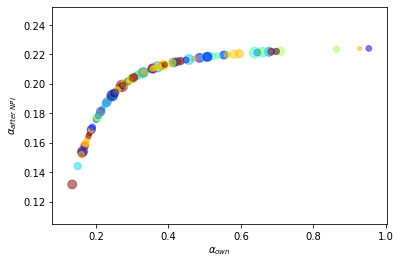

In [75]:
import copy
alpha_after_policy1 = copy.deepcopy(alpha_predicted)
for index, value in enumerate(alpha_predicted):
    alpha_after_policy1[index] = calc_alpha(value, 10000) # We are spending same amount of money in each node, so 10000 per node

scatter_plot(alpha_after_policy1)

### Policy #2

i. 

ii.

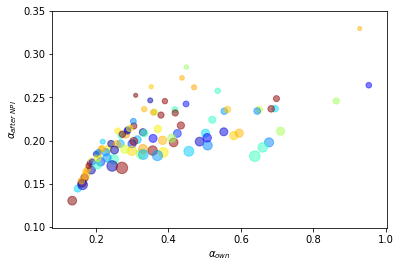

In [76]:
budget = 1000000 # Total to spend
N_proportional = N/N.sum()
alpha_after_policy2 = copy.deepcopy(alpha_predicted)
for index, value in enumerate(alpha_predicted):
    alpha_after_policy2[index] = calc_alpha(value, N_proportional[index]*budget) # We are spending same amount of money in each node, so 10000 per node

scatter_plot(alpha_after_policy2)

### Policy #3

i.

ii.

In [ ]:
def difference_budget(delta_alpha):
    

### Policy #4

i.

ii.

## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4